# Two-Stream Instability

Text retrieved from [1]: *As a final example, we show the two-stream instability in the cold beam regime* [2,3]*. For this scenario, two counter-propagating beams with velocities $\pm v_0$ and no energy spread excite an electrostatic plasma wave that grows exponentially until a significant fraction of particles are trapped inside the electric field, at which point the instability saturates.*

*From linear theory* [2,3]*, we expect that for two cold beams with density $n_{beams} = n_0/2$, the fastest growing mode will correspond to $k=\sqrt{3/8} \cdot\omega_p/v_0$ with a corresponding growth rate of $\gamma = \omega_p/\sqrt{8}$. Therefore, to excite mode $m$, with $k_m = m\pi/L = m\pi / N_{sheets} \delta$, we need to set $v_{0_m} = \sqrt{3/8} \cdot \omega_p N_{sheets}\delta / m\pi$. Furthermore, the number of sheets per wavelength of this mode is given by $N_{\lambda_m} = \lambda_m / \delta = 2N_{sheets}/m \cdot$. Note that both $v_{0_m}$ and $N_{\lambda_m}$ are proportional to the number of sheets used. Therefore, to excite a mode whose wavelength must be resolved by a significant amount of sheets, we need to increase $v_0$ proportionally.*

In this notebook we will show that the GNS is capable of recovering the two-stream instability, even though it is not capable of fully modelling the dynamics since it is limited by its training data regime and graph connectivity. We will use the Sheet Model at higher temporal resolution as ground truth.

**Note**: This notebook takes a long time to run (>1h) due to the Sheet Model simulations and generates ~500MB of output files.

#### References

[1] D. Carvalho et al., arXiv:2310.17646 (2023) - See Section 6.7 <br>
[2] J. Dawson,  *Some Investigations of Plasma Instabilities in One-dimensional Plasmas* - MATT 152 (1962) <br>
[3] F. Chen, Introduction to Plasma Physics and Controlled Fusion Vol. 1 (1984) - See Chapter 6 <br>

In [1]:
import os
import jax
import sys
import pickle
import numpy as np

from pathlib import Path
from tqdm.auto import tqdm

# uncomment the line below for nicer plots (needs LaTeX)
# os.environ['MATPLOTLIBRC'] = '../matplotlibrc'
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter

sys.path.append('../..')
from gns.simulator import SMGNS
from sheet_model.synchronous import SyncSheetModel
from sheet_model.utils import get_mode_info, get_mode_evolution, get_Efield, get_x_eq, get_dx_eq

## dont let JAX preallocate all GPU memory + free unused arrays 
## https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html
## makes code slower
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false" 
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

## Initial Conditions

In [41]:
# ----------------------------------
# Sheet model Simulation Options
opt = {
    'n_guards' : None, # number of guards
    'n_sheets' : 10000, #number of sheets
    'dt' : None, # simulation dt [1/w_p]
    'boundary' : 'periodic', # type (periodic or reflecting)
    'n_it_crossings' : 2, # number of iterations used to solve crossings
    'track_sheets': False,
    'L': 1
}

t_max = 20
dt_undersample = None

# ----------------------------------
# aux variables
dx_eq = get_dx_eq(opt['n_sheets'], opt['L'])
x_eq = get_x_eq(opt['n_sheets'], opt['L'])

# ----------------------------------
# Chosen mode + associated beam velocity
m = 4 # use always an even number so that full periods are generated
v_beam = np.sqrt(3/8) / (m * np.pi) * opt['n_sheets'] # [dx_eq w_p]

# ----------------------------------
# Initial conditions
np.random.seed(42)

x0 = x_eq
v0 = np.random.choice([-1,1], opt['n_sheets']) * v_beam * dx_eq

# ----------------------------------
# Buffer to store results
results = dict()

## Sheet Model

These simulations will take a (very) long time to run (~1h)

In [58]:
DT = np.array([1e-1, 1e-2])
N_GUARDS = [200, 50]

results['sm'] = dict()

for dt, n_guards in zip(DT, N_GUARDS):
    
    print()
    print(f'dt: {dt}')
                      
    opt_aux = dict(opt)
    opt_aux['dt'] = dt
    dt_undersample = int(1e-1/dt)
    opt_aux['n_guards'] = n_guards
    
    # sm sim
    sim = SyncSheetModel(**opt_aux)
    
    X, V, X_eq, E = sim.run_simulation(x0,
                                       v0,
                                       x_eq_0=x_eq,
                                       t_max=t_max,
                                       dt_undersample=dt_undersample,
                                       verbose=True)

    results['sm'][dt] = {'X': X, 'V': V, 'X_eq': X_eq, 'E': E} 
    
    print(f'[SM] dE: {np.mean(E[-int(2*np.pi/1e-1):]-E[0])/E[0]}')


dt: 0.1


  0%|          | 0/200 [00:00<?, ?it/s]

[SM] dE: -0.0012656762417100284

dt: 0.01


  0%|          | 0/2000 [00:00<?, ?it/s]

[SM] dE: -1.2636755580702655e-06


In [33]:
# store as precaution
with open(f'two_stream_sims_{m}.pkl', 'wb') as f:
    pickle.dump(results, f)

## GNS

In [35]:
DT = np.array([1e-1, 1e-2])

results['gns'] = dict()

# ----------------------------------
# GNSimulator

for dt, seed in zip(DT, [4, 0]):
    
    print()
    print(f'dt: {dt}')
    
    model_folder = Path('../../models/final/dt{0:.0e}/'.format(dt).replace('e-0', 'e-') + f'/{seed}/')
    gns = SMGNS(model_folder, opt['boundary'], verbose=False, L=opt['L'])

    X, V, X_eq, E = gns.pred_rollout(x0, 
                                     v0,
                                     x_eq,
                                     t_max=t_max,
                                     dt_undersample=int(1e-1/gns.dt_train),
                                     verbose=True,
                                     track_sheets=False,
                                     np_=np)


    results['gns'][dt] = {'X': X, 'V': V, 'X_eq': X_eq, 'E': E} 

    print(f'[GNS] dE: {np.mean(E[-int(2*np.pi/1e-1):]-E[0])/E[0]}')


dt: 0.1


  0%|          | 0/200 [00:00<?, ?it/s]

[GNS] dE: -0.020182982087135315

dt: 0.01


  0%|          | 0/2000 [00:00<?, ?it/s]

[GNS] dE: 0.02146134153008461


In [36]:
# store as precaution
with open(f'two_stream_sims_{m}.pkl', 'wb') as f:
    pickle.dump(results, f)

## Plot Comparisons

In [42]:
# load results from files
with open(f'two_stream_sims_{m}.pkl', 'rb') as f:
    results = pickle.load(f)

DE/E0 sm 0.01 -1.5035533124993557e-06
DE/E0 gns 0.01 0.017995482308464122


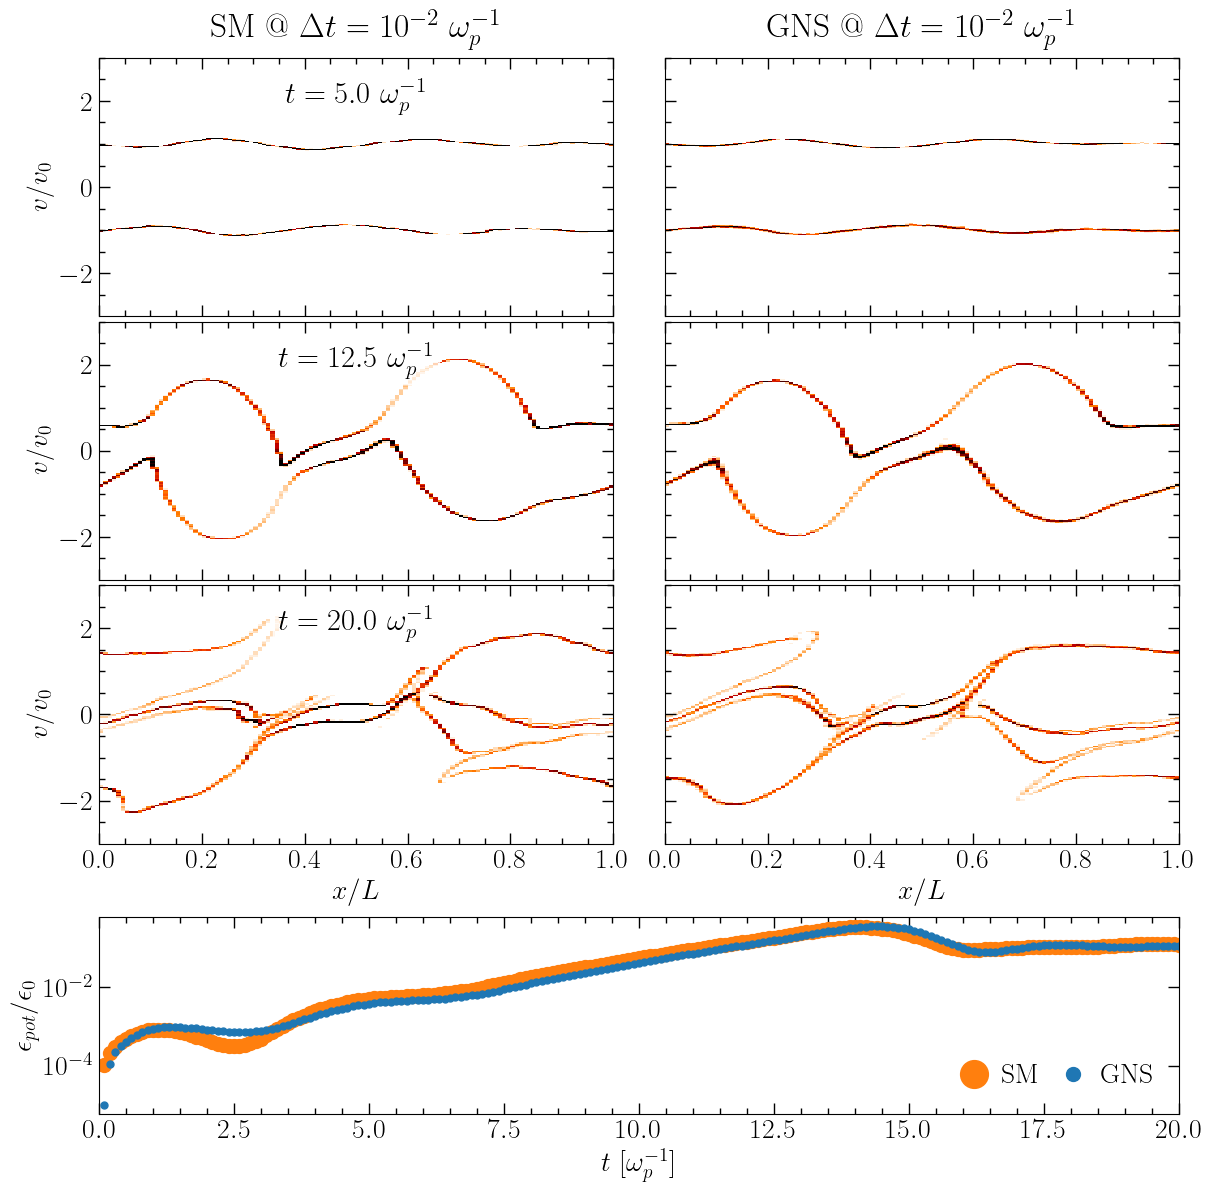

In [54]:
dt_1 = 1e-2
dt_2 = 1e-2

model_1 = 'sm'
model_2 = 'gns'

print('DE/E0', model_1, dt_1, 
      (results[model_1][dt_1]['E'][-1]-results[model_1][dt_1]['E'][0])/results[model_1][dt_1]['E'][0])
print('DE/E0', model_2, dt_2,
      (results[model_2][dt_2]['E'][-1]-results[model_2][dt_2]['E'][0])/results[model_1][dt_1]['E'][0])

fig = plt.figure(figsize=(12, 12))

gs = gridspec.GridSpec(2, 1, figure=fig, 
                       height_ratios=(0.8, 0.2), 
                       wspace=0.1, hspace=0.15,
                       top=0.95, bottom=0.07, left=0.08, right=0.98)

gs_ps = gridspec.GridSpecFromSubplotSpec(3, 2,
                                         height_ratios=(1,1,1), width_ratios=(1,1), 
                                         wspace=0.1, hspace=0.02,
                                         subplot_spec=gs[0])

    
gs_growth = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1])


ax = [[None for j in range(2)] for i in range(3)]

ax[0][0] = fig.add_subplot(gs_ps[0,0])
ax[0][1] = fig.add_subplot(gs_ps[0,1], sharex=ax[0][0])

for i in range(1,len(ax)):
    for j in range(len(ax[i])):
        ax[i][j] = fig.add_subplot(gs_ps[i,j], sharex=ax[0][j], sharey=ax[0][j])
        
ax = np.array(ax)
ax[0,1].set_yticklabels([])

ax[0,0].set_title(f'{model_1.upper()} @ $\Delta t = 10^{{{np.log10(dt_1):0.0f}}}~\omega_p^{{-1}}$', pad=15)
ax[0,1].set_title(f'{model_2.upper()} @ $\Delta t = 10^{{{np.log10(dt_2):0.0f}}}~\omega_p^{{-1}}$', pad=15)

## plot
for i, it in enumerate(np.linspace(len(results[model_1][dt_1]['X'])//4, 
                                   len(results[model_1][dt_1]['X'])-1, 3).astype(np.int32)):
    
    ax[i, 0].hist2d(results[model_1][dt_1]['X'][it]/opt['L'], 
                    results[model_1][dt_1]['V'][it]/v_beam/dx_eq, 
                    bins=[120,120], cmap='gist_heat_r', vmin=0, vmax=30)
    
    ax[i, 1].hist2d(results[model_2][dt_2]['X'][it]/opt['L'], 
                    results[model_2][dt_2]['V'][it]/v_beam/dx_eq, 
                    bins=[120,120], cmap='gist_heat_r', vmin=0, vmax=30)
    
    plt.text(0.5, 0.85, f'$t = {it*1e-1}$ $\omega_p^{{-1}}$', 
             horizontalalignment='center', verticalalignment='center', 
             fontsize=22, transform=ax[i,0].transAxes, bbox={'color':'white', 'alpha':0.7})
    
    
plt.setp(ax[:, 0], ylabel='$v$/$v_0$')
plt.setp(ax[-1,:], xlabel='$x/L$')
plt.setp(ax[:, :], ylim=(-3,3))
plt.setp(ax[:, :], xlim=(0,1))

for a in ax.ravel():
    a.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
for i in range(2):
    for a in ax[i]:
        plt.setp(a.get_xticklabels(), visible=False)

ax_growth = fig.add_subplot(gs_growth[0,0])

t = np.arange(0, t_max + 1e-1, 1e-1)
E0 = 1/2 * opt['n_sheets'] * (v_beam * dx_eq) ** 2
E_pot_1 = 1/2 * np.sum(np.square(results[model_1][dt_1]['X'] - results[model_1][dt_1]['X_eq']), axis=-1)
E_pot_2 = 1/2 * np.sum(np.square(results[model_2][dt_2]['X'] - results[model_2][dt_2]['X_eq']), axis=-1)
,
plt.plot(t, E_pot_1/E0, '.', ms=20, color='tab:orange', label=model_1.upper())
plt.plot(t, E_pot_2/E0, '.', ms=10, color='tab:blue', label=model_2.upper())

ax_growth.set_xlabel('$t$ [$\omega_p^{-1}$]')
ax_growth.set_ylabel('$\epsilon_{pot}/\epsilon_0$')
ax_growth.set_yscale('log')
ax_growth.legend(ncol=3, columnspacing=0.2, handletextpad=0, markerscale=2, loc='lower right')
ax_growth.set_xlim(t[0], t[-1])

plt.savefig(f'../img/twostream_{model_1}_{dt_1}_vs_{model_2}_{dt_2}_{m}.pdf')
plt.show()

## Extra - Test on Multiple GNN seeds

In [44]:
results_seed = {1e-1: dict(), 1e-2:dict()}

for dt in results_seed:
    for seed in np.arange(5):
        
        print()
        print(f'dt: {dt}\t seed: {seed}')

        model_folder = Path('../../models/final/dt{0:.0e}/'.format(dt).replace('e-0', 'e-') + f'/{seed}/')
        gns = SMGNS(model_folder, opt['boundary'], verbose=False, L=opt['L'])

        X, V, X_eq, E = gns.pred_rollout(x0, 
                                         v0,
                                         x_eq,
                                         t_max=t_max,
                                         dt_undersample=int(1e-1/gns.dt_train),
                                         verbose=True,
                                         track_sheets=False,
                                         np_=np)


        results_seed[dt][seed] = {'X': X, 'V': V, 'X_eq': X_eq, 'E': E} 

        print(f'[GNS] dE: {np.mean(E[-int(2*np.pi/1e-1):]-E[0])/E[0]}')


dt: 0.1	 seed: 0


  0%|          | 0/200 [00:00<?, ?it/s]

[GNS] dE: -0.1473105102777481

dt: 0.1	 seed: 1


  0%|          | 0/200 [00:00<?, ?it/s]

[GNS] dE: -0.14587053656578064

dt: 0.1	 seed: 2


  0%|          | 0/200 [00:00<?, ?it/s]

[GNS] dE: -0.10696755349636078

dt: 0.1	 seed: 3


  0%|          | 0/200 [00:00<?, ?it/s]

[GNS] dE: -0.16738910973072052

dt: 0.1	 seed: 4


  0%|          | 0/200 [00:00<?, ?it/s]

[GNS] dE: -0.023660361766815186

dt: 0.01	 seed: 0


  0%|          | 0/2000 [00:00<?, ?it/s]

[GNS] dE: 0.017542585730552673

dt: 0.01	 seed: 1


  0%|          | 0/2000 [00:00<?, ?it/s]

[GNS] dE: -0.05467817932367325

dt: 0.01	 seed: 2


  0%|          | 0/2000 [00:00<?, ?it/s]

[GNS] dE: 0.06719444692134857

dt: 0.01	 seed: 3


  0%|          | 0/2000 [00:00<?, ?it/s]

[GNS] dE: -0.028610462322831154

dt: 0.01	 seed: 4


  0%|          | 0/2000 [00:00<?, ?it/s]

[GNS] dE: -0.5110548138618469


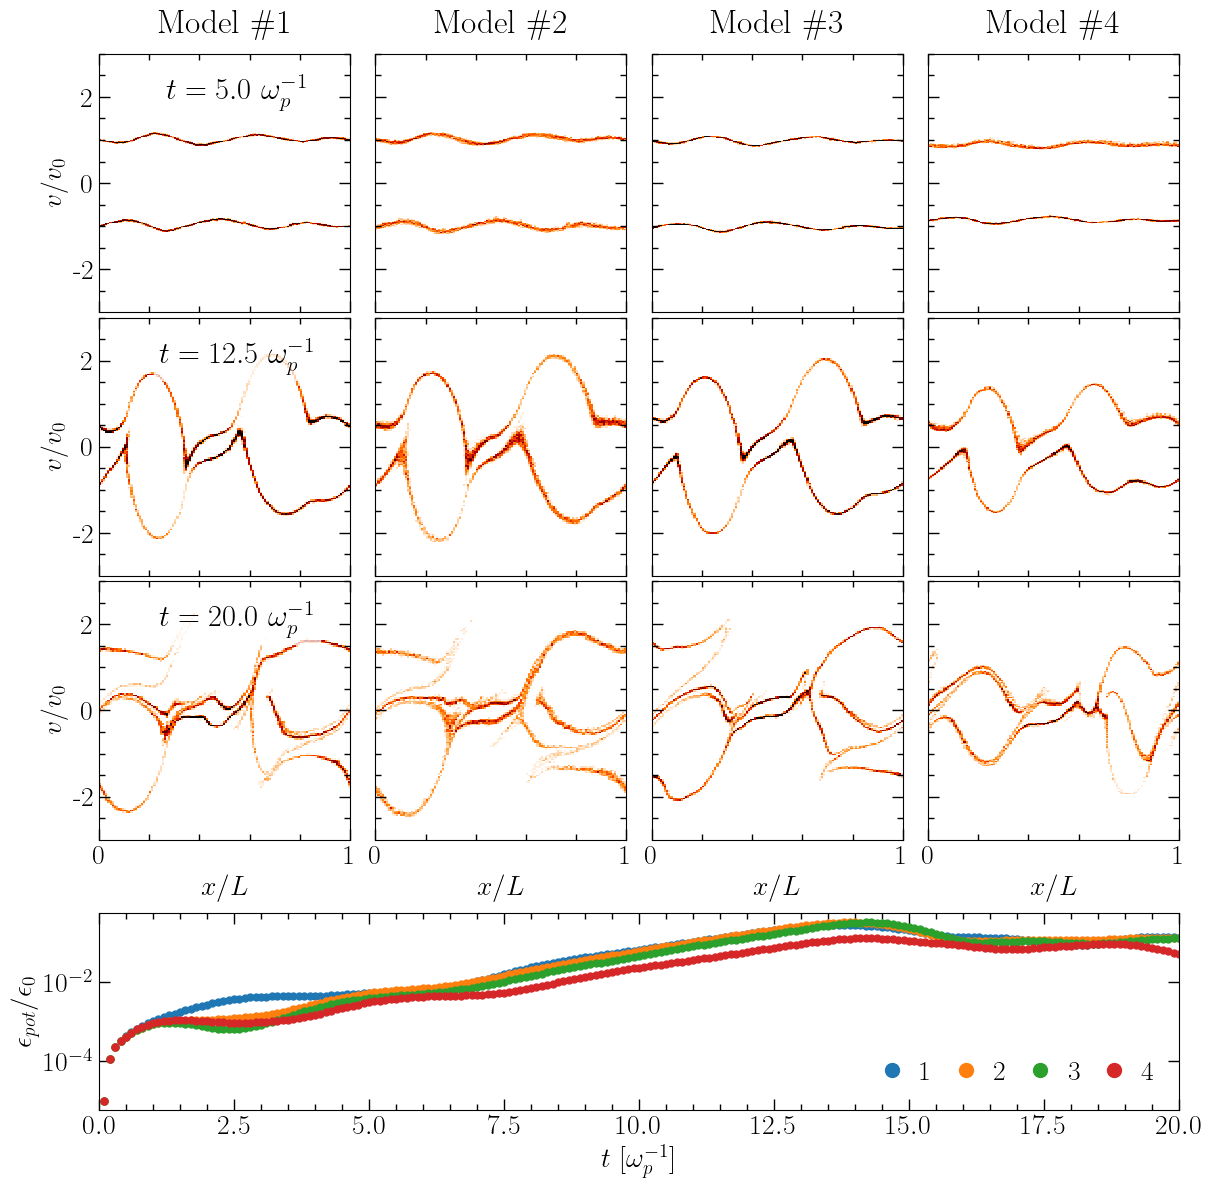

In [53]:
#dt = 1e-1
#seeds = [0,1,2,3]

dt = 1e-2
seeds = [1,2,3,4]

fig = plt.figure(figsize=(12,12))#7*2, 3*4))

gs = gridspec.GridSpec(2, 1, figure=fig, 
                       height_ratios=(0.8, 0.2), 
                       wspace=0.1, hspace=0.15,
                       top=0.95, bottom=0.07, left=0.08, right=0.98)

gs_ps = gridspec.GridSpecFromSubplotSpec(3, len(seeds),
                                         wspace=0.1, hspace=0.02,
                                         subplot_spec=gs[0])

    
gs_growth = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1])

ax = [[None for j in range(len(seeds))] for i in range(3)]

for is_, s in enumerate(seeds):

    if is_ == 0:
        ax[0][is_] = fig.add_subplot(gs_ps[0,is_])
    
    else:
        ax[0][is_] = fig.add_subplot(gs_ps[0,is_], sharex=ax[0][0])
        

    for i in range(1,len(ax)):
        ax[i][is_] = fig.add_subplot(gs_ps[i,is_], sharex=ax[0][is_], sharey=ax[0][is_])
        ax[i][is_].set_yticklabels([])

    ax = np.array(ax)

    ## plot
    for i, it in enumerate(np.linspace(len(results_seed[dt][s]['X'])//4, 
                                       len(results_seed[dt][s]['X'])-1, 3).astype(np.int32)):

        ax[i, is_].hist2d(results_seed[dt][s]['X'][it]/opt['L'], 
                        results_seed[dt][s]['V'][it]/v_beam/dx_eq, 
                        bins=[120,120], cmap='gist_heat_r', vmin=0, vmax=30)
        
        if is_ == 0: 
            plt.text(0.55, 0.85, f'$t = {it*1e-1}$ $\omega_p^{{-1}}$', 
                     horizontalalignment='center', verticalalignment='center', fontsize=22, 
                     transform=ax[i,0].transAxes, bbox={'color':'white', 'alpha':0.7})
            
    
    
    ax[0, is_].set_title(f'Model $\#${s}', pad=15)
    
    
for a in ax.ravel():
    a.set_xticks([0,1])
    a.set_yticks([-2, 0, 2])
    a.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    a.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

for i in range(3):
    for a in ax[i,1:]:
        plt.setp(a.get_yticklabels(), visible=False)
        
for i in range(2):
    for j in range(len(seeds)):
        plt.setp(ax[i,j].get_xticklabels(), visible=False)

        
plt.setp(ax[:, 0], ylabel='$v$/$v_0$')
plt.setp(ax[-1,:], xlabel='$x/L$')
plt.setp(ax[:, :], ylim=(-3,3))
plt.setp(ax[:, :], xlim=(0,1))


ax_growth = fig.add_subplot(gs_growth[0,0])

t = np.arange(0, t_max + 1e-1, 1e-1)
E0 = 1/2 * opt['n_sheets'] * (v_beam * dx_eq) ** 2

for s in seeds:
    E_pot = 1/2 * np.sum(np.square(results_seed[dt][s]['X'] - results_seed[dt][s]['X_eq']), axis=-1)
    ax_growth.plot(t, E_pot/E0, '.', ms=10, label=s)

ax_growth.set_xlabel('$t$ [$\omega_p^{-1}$]')
ax_growth.set_ylabel('$\epsilon_{pot}/\epsilon_0$')
ax_growth.set_yscale('log')
ax_growth.legend(ncol=len(seeds), columnspacing=0.2, handletextpad=0, markerscale=2, loc='lower right')
ax_growth.set_xlim(t[0], t[-1])

plt.savefig(f'../img/twostream_gns_{dt}_m{m}_seeds.pdf')
plt.show()

## Animations

In [57]:
with open(f'two_stream_sims_{m}.pkl', 'rb') as f:
    results = pickle.load(f)

........Done!


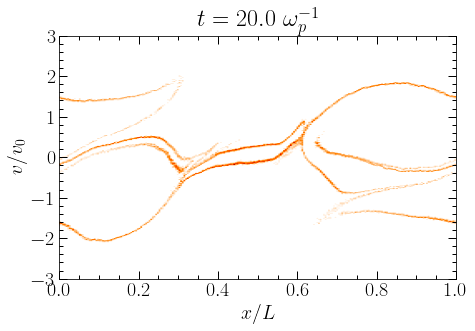

In [58]:
dt = 1e-1
model = 'gns'

X = results[model][dt]['X']
V = results[model][dt]['V']

fps = 30
tframes = np.linspace(0, t_max, len(X))
itframes = np.array(tframes/dt, dtype=int)

fig = plt.figure(figsize=(7,5))

bins = [np.linspace(0,1, 240), np.linspace(-3, 3, 240)]

data, _, _ = np.histogram2d(X[0]/opt['L'], V[0]/dx_eq/v_beam, bins=bins)

im = plt.imshow(data.T, cmap='gist_heat_r', origin='lower', aspect='auto',
                extent=[bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]])

ax = plt.gca()
ax.set_title(f"$t = 0.0 \ \omega_p^{{-1}}$")
plt.ylabel('$v/v_0$')
plt.xlabel('$x/L$')
plt.tight_layout()

def animate_func(i):
    
    if i % fps == 0:
        print('.', end='')
        
    data, _, _ = np.histogram2d(X[itframes[i]]/opt['L'], V[itframes[i]]/dx_eq/v_beam, bins=bins)
    im.set_data(data.T)
    
    ax.set_title(f"$t = {tframes[i]:.1f} \ \omega_p^{{-1}}$")
        
        
anim = animation.FuncAnimation(fig, 
                               animate_func, 
                               frames=len(tframes),
                               interval=1000/fps)

anim.save('../img/twostream_single.mp4', fps=fps)

print('Done!')

........Done!


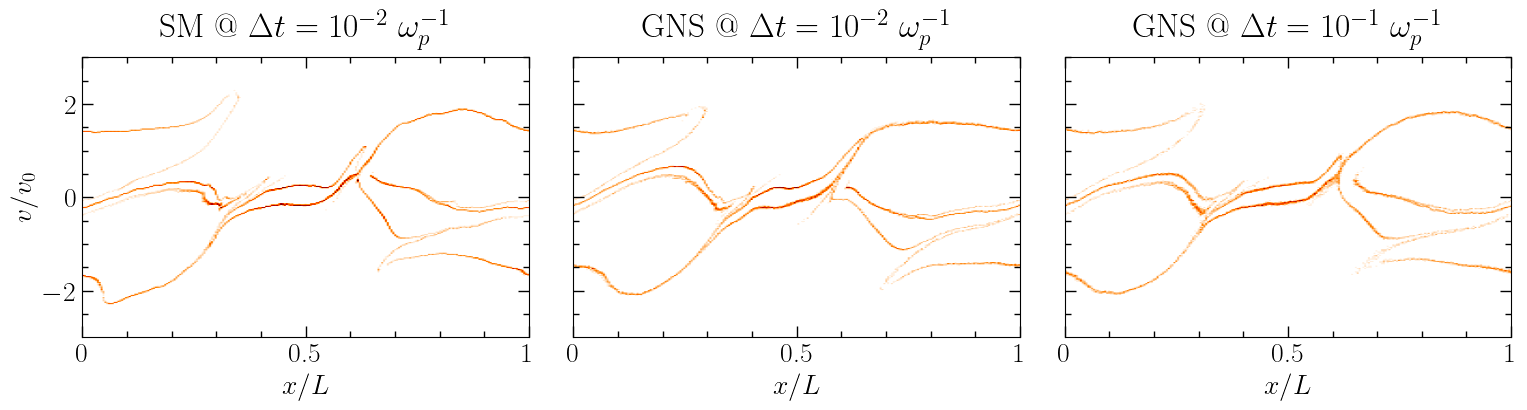

In [59]:
dt = 1e-1

dt_1 = 1e-2
dt_2 = 1e-2
dt_3 = 1e-1

model_1 = 'sm'
model_2 = 'gns'
model_3 = 'gns'

models = [model_1, model_2, model_3]
dts = [dt_1, dt_2, dt_3]

X = [results[m][d]['X'] for m,d in zip(models, dts)]
V = [results[m][d]['V'] for m,d in zip(models, dts)]

fps = 30
tframes = np.linspace(0, t_max, len(X[0]))
itframes = np.array(tframes/dt, dtype=int)
bins = [np.linspace(0,1, 240), np.linspace(-3, 3, 240)]

fig, ax = plt.subplots(1, 3, figsize=(19*4/5,5*4/5), sharex=True, sharey=True,
                       gridspec_kw={'wspace': 0.1, 'top': 0.85, 'bottom': 0.15, 'left': 0.05, 'right': 0.99})

im = []

for i in range(len(X)):
    data, _, _ = np.histogram2d(X[i][0]/opt['L'], V[i][0]/dx_eq/v_beam, bins=bins)

    im.append(ax[i].imshow(data.T, cmap='gist_heat_r', origin='lower', aspect='auto',
                           extent=[bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]],
                           vmin=0, vmax=30)
             )

    ax[i].set_title(f'{models[i].upper()} @ $\Delta t = 10^{{{np.log10(dts[i]):0.0f}}}~\omega_p^{{-1}}$', pad=15)
    ax[i].set_xticks([0, 0.5, 1.0])
    ax[i].set_xticklabels([0, 0.5, 1])
    
ax[0].set_ylabel('$v/v_0$')
plt.setp(ax, xlabel='$x/L$')


def animate_func(i):
    
    if i % fps == 0:
        print('.', end='')
        
    for j in range(len(X)):

        data, _, _ = np.histogram2d(X[j][itframes[i]]/opt['L'], V[j][itframes[i]]/dx_eq/v_beam, bins=bins)
        im[j].set_data(data.T)
        
        
anim = animation.FuncAnimation(fig, 
                               animate_func, 
                               frames=len(tframes),
                               interval=1000/fps)

anim.save('../img/twostream_comparison.mp4', fps=fps)

print('Done!')